Setting

In [1]:
import os
import sys

FIGURE_DIR = os.getcwd()
MIL_DIR = os.path.dirname(FIGURE_DIR)
NB_DIR = os.path.dirname(MIL_DIR)
ROOT_DIR = os.path.dirname(NB_DIR)
EXP_DIR = os.path.join(ROOT_DIR)
sys.path.append(ROOT_DIR)

from mlflow_settings import TRACKING_URI

In [2]:
import mlflow
from setting import PARENT_RUN_ID, PARENT_RUN_ID_WO_RANK

client = mlflow.MlflowClient(TRACKING_URI)
child_run_ids = list()
child_run_ids_wo_rank = list()
for run in client.search_runs(experiment_ids=[6]):

    if "mlflow.parentRunId" not in run.data.tags:
        continue

    if run.data.tags["mlflow.parentRunId"] == PARENT_RUN_ID:
        child_run_ids.append(run.info.run_id)

    if run.data.tags["mlflow.parentRunId"] == PARENT_RUN_ID_WO_RANK:
        child_run_ids_wo_rank.append(run.info.run_id)

In [4]:
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu as mu_test
data = list()

metrics = ["f1", "topk_any_5", "topk_any_5_cnv"]
for run_id in child_run_ids:
    run_metrics = list()
    for metric in metrics:
        if not client.get_metric_history(run_id, metric):
            continue
        value = client.get_metric_history(run_id, metric)[0].value
        
        run_metrics.append(value)

    if not run_metrics:
        continue
    data.append(["ranknet"] + run_metrics)


for run_id in child_run_ids_wo_rank:
    run_metrics = list()
    for metric in metrics:
        value = client.get_metric_history(run_id, metric)[0].value
        run_metrics.append(value)

    data.append(["wo_ranknet"] + run_metrics)


res = list()
df = pd.DataFrame(data, columns=["loss"] + metrics)
for metric in metrics:
    x = df.loc[df["loss"] == "ranknet" , metric].tolist()
    y = df.loc[df["loss"] == "wo_ranknet", metric].tolist()
    
    # print(x, y)
    print(metric, ":", f"{round(np.mean(x), 4)} ({round(np.std(x), 4)})", f"{round(np.mean(y), 4)} ({round(np.std(y), 4)})", mu_test(x, y, alternative="two-sided", method="exact"))

f1 : 0.8317 (0.0145) 0.8658 (0.007) MannwhitneyuResult(statistic=0.0, pvalue=0.007936507936507936)
topk_any_5 : 0.9683 (0.0028) 0.9423 (0.0246) MannwhitneyuResult(statistic=25.0, pvalue=0.007936507936507936)
topk_any_5_cnv : 0.9422 (0.0199) 0.8223 (0.0392) MannwhitneyuResult(statistic=25.0, pvalue=0.007936507936507936)


In [43]:
stacked_df

,loss,metric,value
10,3ASC W/ RankNet,topk_any_5,0.969920
11,3ASC W/ RankNet,topk_any_5,0.964395
12,3ASC W/ RankNet,topk_any_5,0.971148
13,3ASC W/ RankNet,topk_any_5,0.965623
14,3ASC W/ RankNet,topk_any_5,0.970534
15,3ASC W/O RankNet,topk_any_5,0.894414
16,3ASC W/O RankNet,topk_any_5,0.957029
17,3ASC W/O RankNet,topk_any_5,0.960712
18,3ASC W/O RankNet,topk_any_5,0.955801
19,3ASC W/O RankNet,topk_any_5,0.943524


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

topk_any_5_cnv_3ASC W/ RankNet v.s. topk_any_5_cnv_3ASC W/O RankNet: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.587e-02 U_stat=2.500e+01
topk_any_5_3ASC W/ RankNet v.s. topk_any_5_3ASC W/O RankNet: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.587e-02 U_stat=2.500e+01


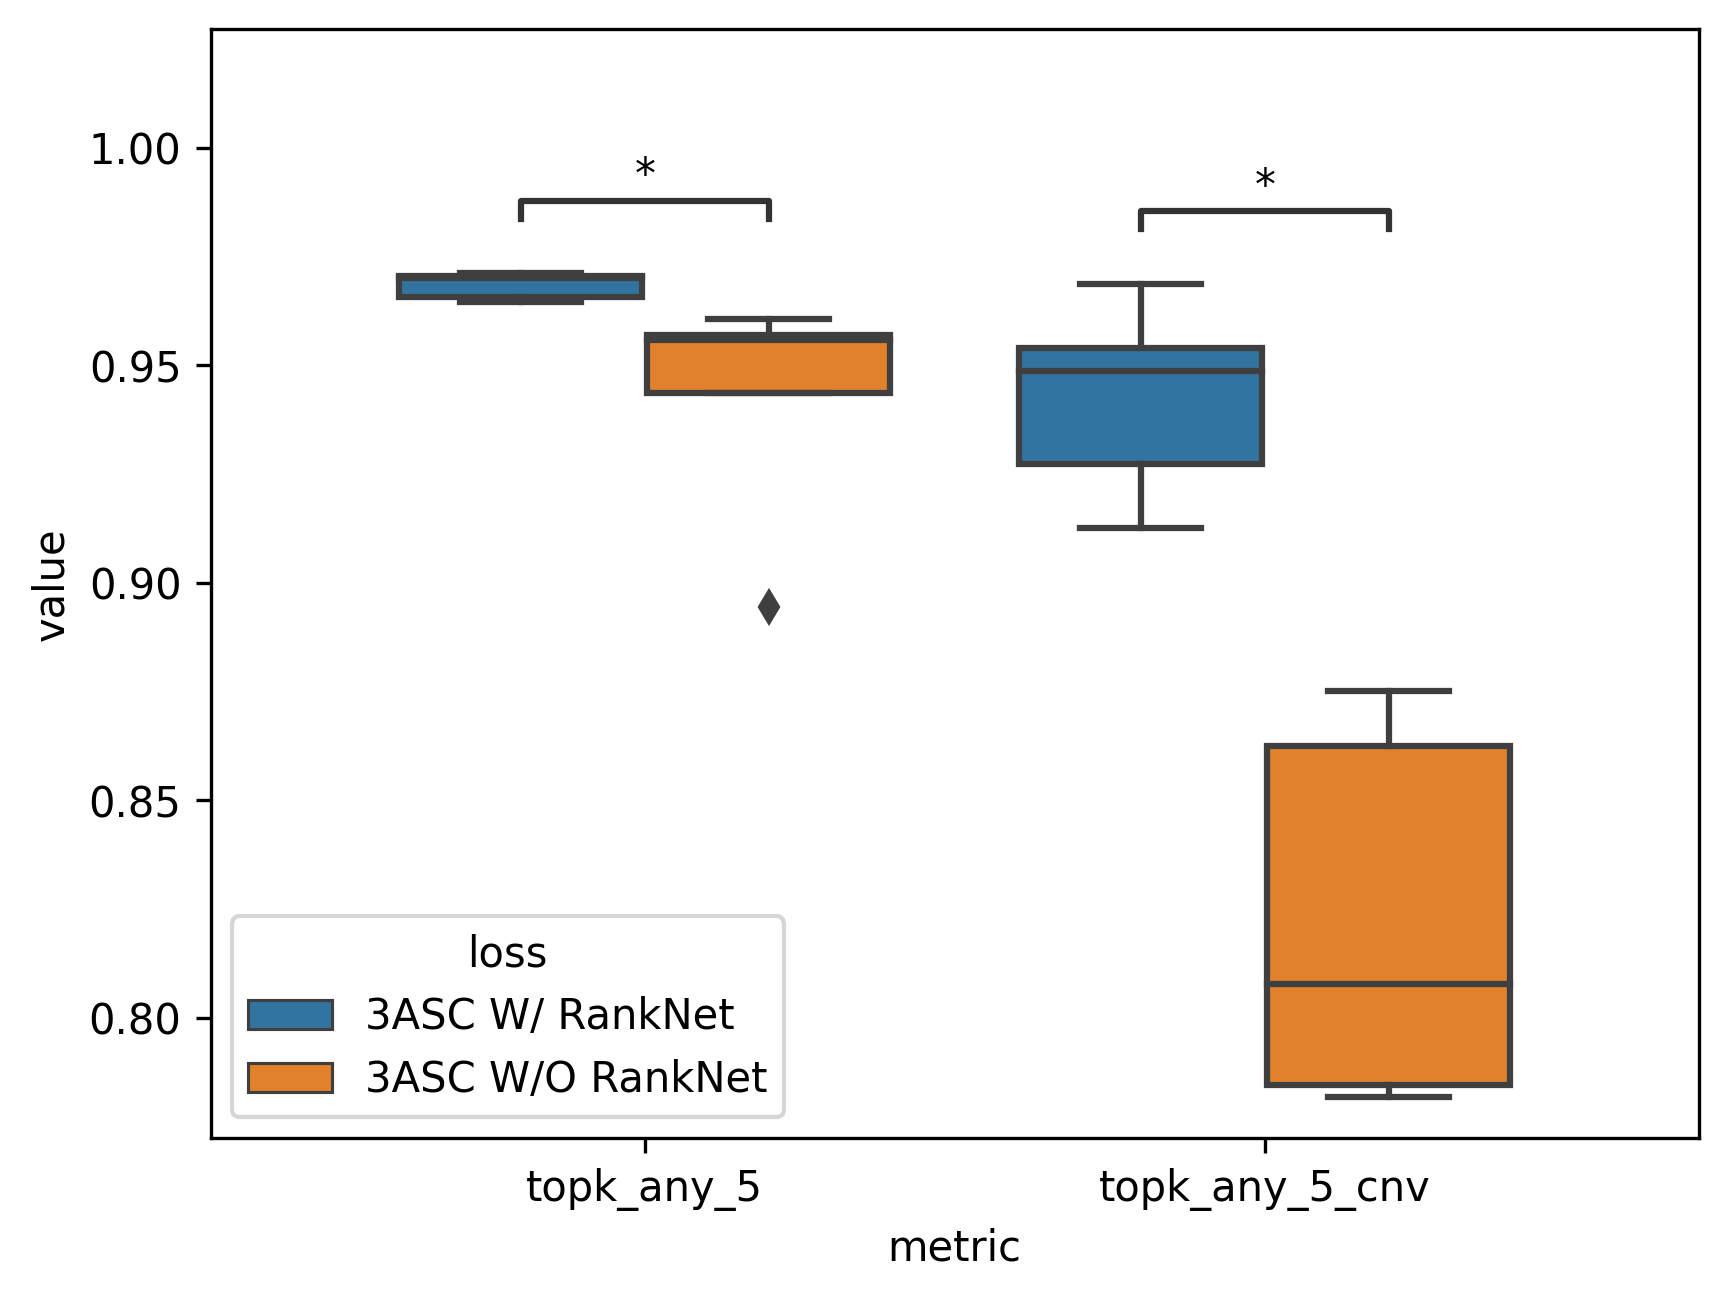

In [42]:
import seaborn as sns
from matplotlib import pyplot as plt
from statannot import add_stat_annotation
stacked_df = pd.melt(df, id_vars=['loss'], var_name='metric', value_name='value')
stacked_df = stacked_df.loc[stacked_df["metric"] != "f1"]
stacked_df = stacked_df.replace({"ranknet":"3ASC W/ RankNet", "wo_ranknet":"3ASC W/O RankNet"})

fig, axes = plt.subplots(dpi=300)
ax = sns.boxplot(
    data=stacked_df,
    x="metric",
    y="value",
    hue="loss",
    ax=axes
)
add_stat_annotation(ax,
                    data=stacked_df,
                    x="metric",
                    y="value",
                    hue="loss",
                    box_pairs=[(("topk_any_5", "3ASC W/ RankNet"), ("topk_any_5", "3ASC W/O RankNet")),
                               (("topk_any_5_cnv", "3ASC W/ RankNet"), ("topk_any_5_cnv", "3ASC W/O RankNet"))],
                    test='Mann-Whitney',
                    text_format='star',
                    loc='inside',
                    verbose=2)

plt.savefig("figure3_ranknet.png")

